In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from functools import partial, reduce
import re, math, random

In [4]:
#
# functions for working with vectors
#

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

## 8.1 梯度下降思想

## 8.2 估算梯度   
差商估算法：直接使用微分的定義暴力估算

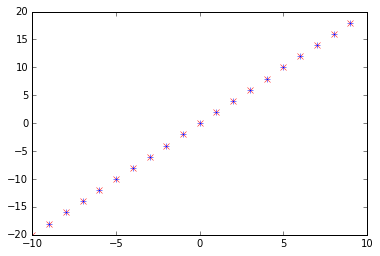

In [5]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def plot_estimated_derivative():

    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

    # plot to show they're basically the same
    import matplotlib.pyplot as plt
    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx')           # red  x
    plt.plot(x, list(map(derivative_estimate, x)), 'b+')  # blue +
    plt.show()                                      # purple *, hopefully

plot_estimated_derivative()

In [6]:
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

## 8.3 使用梯度
這個範例很奇怪，沒有使用微分，就是直接拿結果值硬幹，換句話說步長是錯的   
阿，我誤會了，我們算的是平方，他已過一次了

In [7]:
def step(v, direction, step_size):
    """
    move step_size in the direction from v
    搞笑，方向應該是逆梯度，但不包含在這個函數，在 step_size 的參數中加上負值
    """
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

# 對平方作微分
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v) 
    print(v)
    print(gradient)
    next_v = step(v, gradient, -0.01) #搞笑，步長是負的參數放在這裡
    if distance(next_v, v) < tolerance:
        break
    v = next_v
v

[5, 7, 1]
[10, 14, 2]
[4.9, 6.86, 0.98]
[9.8, 13.72, 1.96]
[4.8020000000000005, 6.7228, 0.9604]
[9.604000000000001, 13.4456, 1.9208]
[4.70596, 6.588344, 0.941192]
[9.41192, 13.176688, 1.882384]
[4.6118408, 6.45657712, 0.92236816]
[9.2236816, 12.91315424, 1.84473632]
[4.519603984000001, 6.327445577600001, 0.9039207968]
[9.039207968000001, 12.654891155200001, 1.8078415936]
[4.429211904320001, 6.200896666048001, 0.885842380864]
[8.858423808640001, 12.401793332096002, 1.771684761728]
[4.3406276662336, 6.076878732727041, 0.86812553324672]
[8.6812553324672, 12.153757465454081, 1.73625106649344]
[4.253815112908928, 5.9553411580725, 0.8507630225817856]
[8.507630225817856, 11.910682316145, 1.7015260451635712]
[4.1687388106507495, 5.83623433491105, 0.8337477621301499]
[8.337477621301499, 11.6724686698221, 1.6674955242602998]
[4.085364034437735, 5.71950964821283, 0.8170728068875469]
[8.17072806887547, 11.43901929642566, 1.6341456137750938]
[4.00365675374898, 5.605119455248573, 0.800731350749796]


[2.8309741083437825e-06, 3.963363751681292e-06, 5.661948216687558e-07]

## 8.4 選擇正確步長
選擇步長是藝術，這裡建議每一步使用最小化目標函數來達到   
但是有些步長可能會導致錯誤，所以要加一個safe函數，如下  


In [8]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

## 8.5 綜合
這個範例很奇怪，沒有使用微分，就是直接拿結果值硬幹

In [16]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn) # 注意 key 的妙用
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

In [17]:
print("using minimize_batch")

v = [random.randint(-10,10) for i in range(3)]

v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

print("minimum v", v)
print("minimum value", sum_of_squares(v))

using minimize_batch
minimum v [0.00016615349947311455, 0.0006646139978924582, -0.0014953814952580302]
minimum value 2.705484567941901e-06


In [18]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

## 8.6 隨機梯度下降法
這個範例很奇怪，沒有使用微分，就是直接拿結果值硬幹